In [1]:
import pandas as pd
import numpy as np
import re
import matplotlib.pyplot as plt

### Reading Kendall data

In [2]:
kend_data = pd.read_csv("/home/sonakshireddy/Documents/yearly_data/Kendall_AZ_,2015.csv")
kend_data.index = pd.to_datetime(kend_data.date)
del kend_data['date']
kend_data = kend_data[['Kendall_AZ_n=1403_d=5']]
kend_data = kend_data.dropna(axis=0,how='all')

### Reading Ameriflux data for tonzi (commented one is for kendall)

In [13]:
# ameri_data = pd.read_csv("/home/sonakshireddy/Downloads/AMF_US-MtB_BASE-BADM_1-5/AMF_US-MtB_BASE_HH_1-5.csv")
ameri_data = pd.read_csv("/home/sonakshireddy/Downloads/AMF_US-Ton_BASE-BADM_11-5/AMF_US-Ton_BASE_HH_11-5.csv")

In [14]:
ameri_data['TIMESTAMP_START'] = pd.to_datetime(ameri_data['TIMESTAMP_START'],format = '%Y%m%d%H%M')
ameri_data['TIMESTAMP_END'] = pd.to_datetime(ameri_data['TIMESTAMP_END'],format = '%Y%m%d%H%M')
ameri_data.index = ameri_data['TIMESTAMP_START']
del ameri_data['TIMESTAMP_START']
del ameri_data['TIMESTAMP_END']
ameri_data = ameri_data.replace(-9999.0,np.nan)
ameri_data = ameri_data.dropna(axis=0,how='all')
ameri_data = ameri_data.resample('H').mean()


### Print start and end dates of data for each column in ameriflux data

In [15]:
def check_dates(col):
    col = col.dropna()
    col = col.resample('H').mean()
    return col.index[0],col.index[-1]

In [20]:
ameri_data.apply(lambda x: print(check_dates(x)),axis=0) 

### Filtering columns in ameriflux df

In [17]:
list_columns=[]
list_columns.append('P')
list_columns.extend([re.match("SWC_.*",x).group() for x in ameri_data.columns if re.match("SWC_.*",x) is not None])
list_columns.extend([re.match("TA.*",x).group() for x in ameri_data.columns if re.match("TA.*",x) is not None])
list_columns.extend([re.match("TS.*",x).group() for x in ameri_data.columns if re.match("TS.*",x) is not None])

In [18]:
ameri_data = ameri_data[list_columns]
ameri_data = ameri_data[ameri_data>=0]

### Reading csv file containing hourly data of all the depth = 5 sites in soilscape

In [21]:
filtered = pd.read_csv("/home/sonakshireddy/Documents/soil/soil/pred_exp/merge_all_result_hourly.csv",sep=";")
filtered = filtered.sort_values(by=['date'])
filtered = filtered.dropna(how='all',axis=0)
filtered.index = pd.to_datetime(filtered.date)
fil_col = [re.match("TerradOro_CA.*|TonziRanch_CA.*",x).group() for x in filtered.columns if re.match("TerradOro_CA_.*|TonziRanch_CA.*",x) is not None]
filtered = filtered[fil_col]
filtered = filtered.resample('H').mean()

### Merging the ameriflux data and hourly data of soilscape 

In [22]:
df = filtered.merge(ameri_data,right_index=True,left_index=True,how='outer')
df = df[['TonziRanch_CAn=408_d=5', 'P', 'SWC_PI_F_1_1_A', 'TA_PI_F_1_1_1', 'TS_PI_F_1_1_A']]

In [23]:
for i in df.columns:
    print(df[i].dropna().shape,i)

(47965,) TonziRanch_CAn=408_d=5
(162480,) P
(162480,) SWC_PI_F_1_1_A
(162294,) TA_PI_F_1_1_1
(162480,) TS_PI_F_1_1_A


### Correlation plot of the above merged df

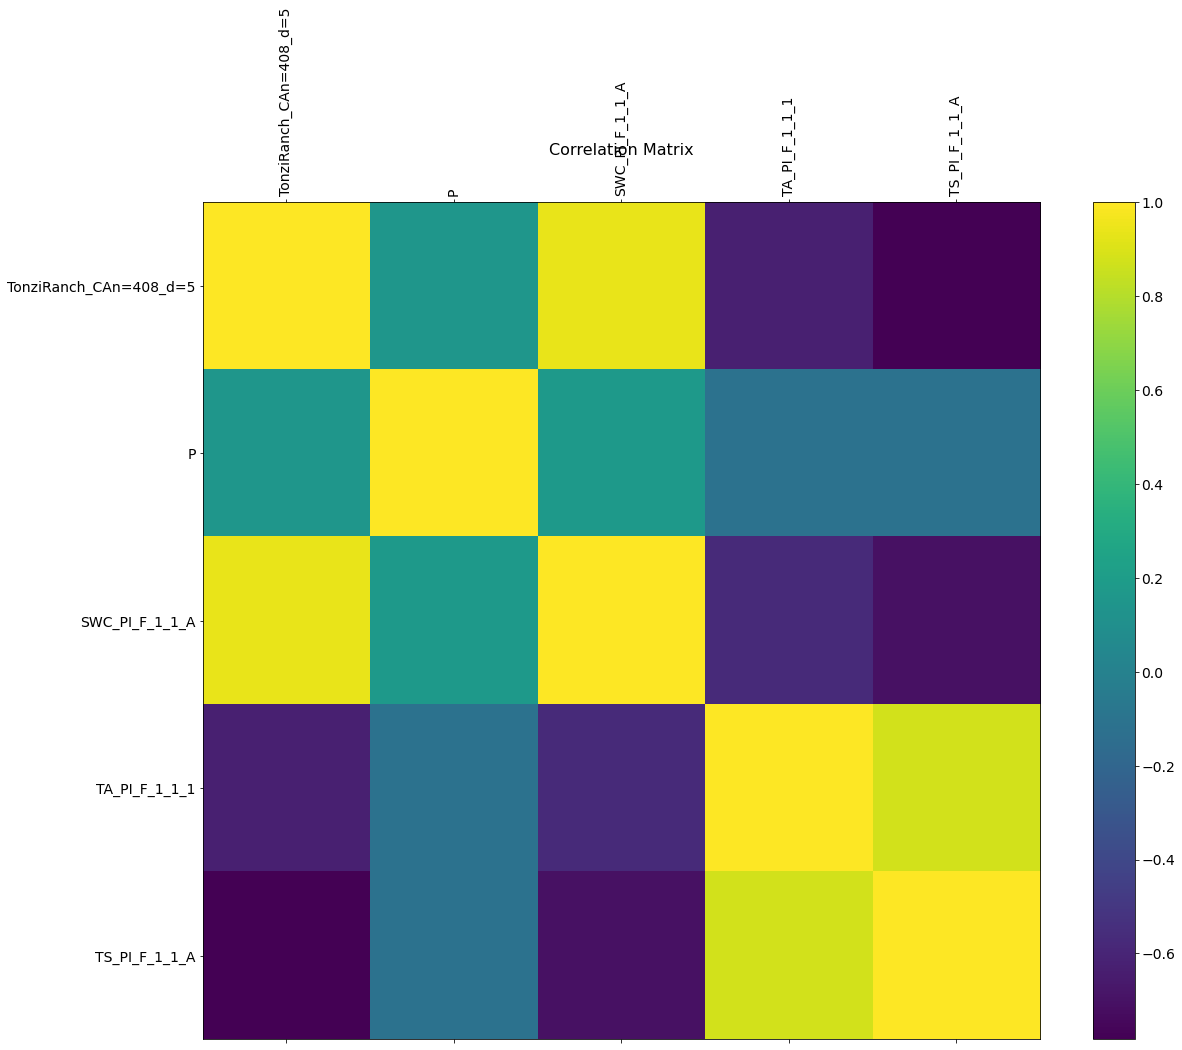

In [24]:
c = df.corr()
f = plt.figure(figsize=(19, 15))
plt.matshow(c, fignum=f.number)
plt.xticks(range(df.shape[1]), df.columns, fontsize=14, rotation=90)
plt.yticks(range(df.shape[1]), df.columns, fontsize=14)
cb = plt.colorbar()
cb.ax.tick_params(labelsize=14)
plt.title('Correlation Matrix', fontsize=16);
# f.savefig(path + '.png')

In [ ]:
df['date'] = df.index
df.to_csv("/home/sonakshireddy/Documents/soil/merged_data_tonzi.csv")

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x7f7f165ba7b8>,
      dtype=object)

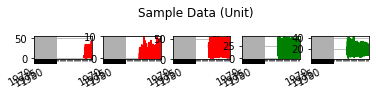

In [28]:
df.plot(kind='line', subplots=True, grid=True, title="Sample Data (Unit)",
    layout=(7, 5), sharex=True, sharey=False, legend=False,    
    style=['r', 'r', 'r', 'g', 'g', 'g', 'b', 'b', 'b', 'r', 'r', 'r'],
    xticks=np.arange(0, len(df), 16))